#### Example using DEMReg and SDO/AIA data
Here using a single pixel of SDO/AIA data taken from the event featured in [Hannah & Kontar 2013 A&A](https://doi.org/10.1051/0004-6361/201219727). 

26-Oct-2020 IGH\
04-Nov-2020 IGH - Updated to use v10 aia deg_cor

In [1]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
from dn2dem_pos import dn2dem_pos
import glob

import astropy.time as atime
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map

from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

In [2]:
# Get your AIA data from somewhere like vso or through sunpy and fido
# Now load in the fits files
fdir='/Users/iain/Downloads/' 
ff=sorted(glob.glob(fdir+'aia.lev1*.fits'))
print(ff)

# This data is from the event in Hannah & Kontar 2013 A&A 
#  https://doi.org/10.1051/0004-6361/201219727


['/Users/iain/Downloads/aia.lev1.131A_2010-11-03T12_15_09.62Z.image_lev1.fits', '/Users/iain/Downloads/aia.lev1.171A_2010-11-03T12_15_12.34Z.image_lev1.fits', '/Users/iain/Downloads/aia.lev1.193A_2010-11-03T12_15_19.84Z.image_lev1.fits', '/Users/iain/Downloads/aia.lev1.211A_2010-11-03T12_15_12.62Z.image_lev1.fits', '/Users/iain/Downloads/aia.lev1.335A_2010-11-03T12_15_15.62Z.image_lev1.fits', '/Users/iain/Downloads/aia.lev1.94A_2010-11-03T12_15_14.12Z.image_lev1.fits']


In [3]:
# Load in the data, will worry about the order later
amaps=sunpy.map.Map(ff)

In [4]:
# aiaprep the images, may take a while to run
# depending on what you are doing could skip this step
aprep=[]
for m in amaps:
    m_temp = update_pointing(m)
    aprep.append(register(m_temp))

In [5]:
# Get the durations for the DN/px/s normalisation and
# wavenlength to check the order
durs=[]
wvn=[]
for m in aprep:
    durs.append(m.meta['exptime'])
    wvn.append(m.meta['wavelnth'])
durs=np.array(durs)
wvn=np.array(wvn)
print(durs)
print(wvn)

[2.901394 2.000186 2.000083 2.90081  2.900859 2.901069]
[131 171 193 211 335  94]


[2453.46991753 2271.50212011 5871.11856135 2859.16149463  203.5119753
  374.10259361]


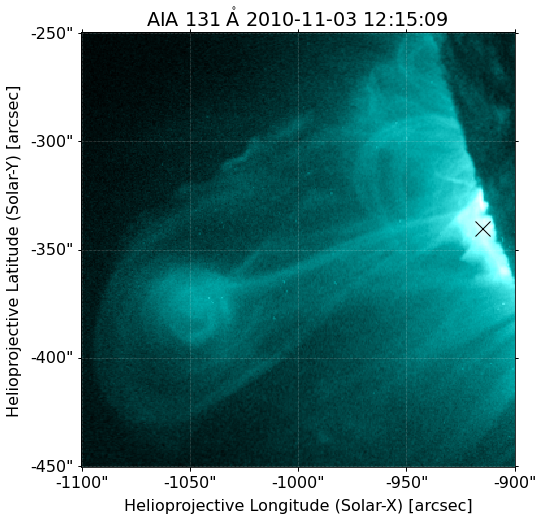

In [6]:
# use Sunpy to help work out pixel location for DEM calculation if know 
# or can just go directly if you already know pixel indices, i.e. m.data[100,100]
# The below pixel is roughly pixel 6 in fig 2 from https://doi.org/10.1051/0004-6361/201219727
px=-915*u.arcsec
py=-340*u.arcsec
data=[]
for m in aprep:
    px_loc=m.world_to_pixel(SkyCoord(px,py, frame=m.coordinate_frame))
#   print(px_loc)
#   Remember python array is first dimension row (y), second dimension x (column) - opposite of idl
    data.append(m.data[int(px_loc[1].value),int(px_loc[0].value)])
data=np.array(data)
# Only doing 1 pixel so immediately in units of DN/px
print(data)

# Plot where the coords is we are looking at
# Probably want to do this before the above lines to work out what pixel/region you need
bottom_left = SkyCoord(-1100*u.arcsec,-450*u.arcsec, frame=aprep[0].coordinate_frame)
top_right = SkyCoord(-900*u.arcsec,-250*u.arcsec, frame=aprep[0].coordinate_frame)
mm = aprep[0].submap(bottom_left, top_right=top_right)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(projection=mm)
mm.plot()
ax.plot_coord(SkyCoord(px,py, frame=mm.coordinate_frame), 'kx', fillstyle='none', markersize=15)
plt.show()

In [7]:
# Just check things are sorted in the correct order of [94,131,171,193,211,335]
worder=np.argsort(wvn)
durs=durs[worder]
data=data[worder]

In [9]:
# Let's get the degradation correction factors
channels = [94,131,171,193,211,335] * u.angstrom
time=atime.Time('2010-11-03T12:15:00', scale='utc')
# print(channels)
# print(time.isot)

# nc=len(channels)
# degs=np.empty(nc)
# for i in np.arange(nc):
#       degs[i]=degradation(channels[i],time,calibration_version=10)
# print(degs)
# # for speed just save in here and manually define
# # v9 values
# # degs=np.array([1.14705432, 0.91535957, 0.97148718, 0.98810095, 0.97238522, 0.83229072])
# # v10 values
degs=np.array([1.14278863, 0.91401251, 0.99550979, 0.98652938, 0.97036462, 0.83094366])

print(degs)


[1.14278863 0.91401251 0.99550979 0.98652938 0.97036462 0.83094366]


In [10]:
# correct for the degradation
cor_data=data/degs

In [11]:
# Now load in the response factors
# Load in the SSWIDL generated response functions
# Was produced by make_aiaresp_forpy.pro (can't escape sswidl that easily....)
trin=io.readsav('aia_trespv9_en.dat')

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]

In [12]:
# Get the data in the correct format for the DEM code, i.e.
# array of data and uncertainty in DN/px/s
dn_in=cor_data/durs
print('dn_in: ',dn_in)

# And the associated uncertainty
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
shotnoise=(dn2ph*cor_data)**0.5/dn2ph
# error in DN/px/s
edn_in=(rdnse**2+shotnoise**2)**0.5/durs
print('edn_in: ',edn_in)
# You might also want to include a systematic uncertainty...

dn_in:  [ 112.84095421  925.17073956 1140.76773171 2975.51955323 1015.74442877
   84.42902445]
edn_in:  [ 8.7730125  21.67902861 25.30688068 37.83167679 17.55634792  4.11513239]


In [13]:
#  What temperature binning do we want for the output DEM?
#  These are the bin edges
#  Need to tweak the range based on what you are looking at
temps=np.logspace(5.7,7.6,num=42)
# Temperature bin mid-points for DEM plotting
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

Executing in serial
total elapsed time = 0:00:00.041698


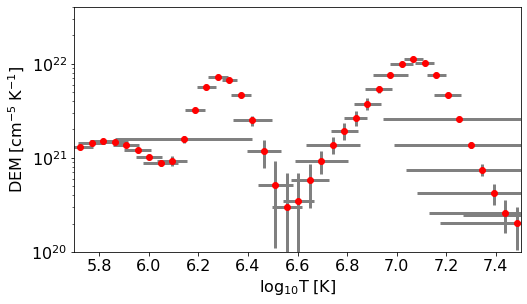

In [14]:
# Work out the DEM
dem,edem,elogt,chisq,dn_reg=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps)

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem,xerr=elogt,yerr=edem,fmt='or',ecolor='gray', elinewidth=3, capsize=0)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([1e20,4e22])
plt.xlim([5.7,7.5])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()

Executing in serial
total elapsed time = 0:00:00.004228


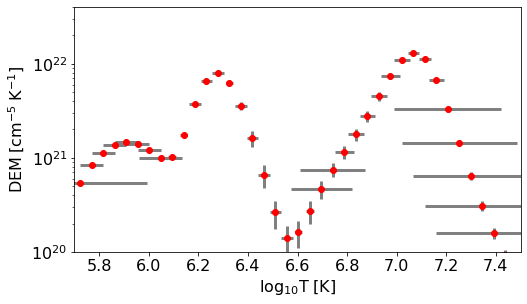

In [15]:
# Now that we have a rough DEM solution could run it again using 
# this to weight the DEM solution. Original idl version of DEM code did this by default 
# but mapping removed it as slower overall, but only 1 pixel so speed not an issue
dem_norm0=dem/np.max(dem)
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,dem_norm0=dem_norm0)

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',ecolor='gray', elinewidth=3, capsize=0)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([1e20,4e22])
plt.xlim([5.7,7.5])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.title('')
plt.savefig('demregpy_aiapxl.png',bbox_inches='tight')
plt.show()